In [72]:
raw_counts = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.raw.counts.matrix-2.txt', sep = '\t')
rnaseq_df_init = pd.read_csv('../data/Deconvo2.csv', sep=',', index_col=0)
rnaseq_df_reset = rnaseq_df_init.reset_index()
rnaseq_df = rnaseq_df_reset.rename(columns = {"index": "Case ID"})
rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')

In [117]:
# raw_counts

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#md = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/soft_label.tsv', sep='\t', index_col=0)
# import data
brca_df = pd.read_csv('../data/softlabels_per_Subtype.csv', sep=',', index_col=0)
rnaseq_df_init = pd.read_csv('../data/Deconvo2.csv', sep=',', index_col=0)
rnaseq_df_reset = rnaseq_df_init.reset_index()
rnaseq_df = rnaseq_df_reset.rename(columns = {"index": "Case ID"})
rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')

map = {}
og_rna_df = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt')
for i, v in enumerate(og_rna_df.columns):
    if i > 2:
        map[v.split('|')[0]] =v.split('|')[1]


# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']
#brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] == '0']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

# keep common samples

#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))

# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
rnaseq_df_common.rename(columns=map, inplace=True)
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)
# Check for duplicates in rnaseq_df_common's Case ID
print("Duplicate Case IDs in rnaseq_df:", rnaseq_df_common['Case ID'].duplicated().sum())

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

# Verify the shapes after removing duplicates
print("\nAfter removing duplicates:")
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

# Verify that we have exactly the same samples in both dataframes
rnaseq_samples = set(rnaseq_df_common['Case ID'])
brca_samples = set(brca_df_common.index)
print("\nSamples match:", rnaseq_samples == brca_samples)
print("Number of samples in each:", len(rnaseq_samples), len(brca_samples))

rnaseq_df_common.set_index('Case ID', inplace=True)
rnaseq_df_common.head()

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()

# Verify indices match exactly
indices_match = (rnaseq_df_common.index == brca_df_common.index).all()
print("\nIndices match exactly:", indices_match)

print(brca_df_common.shape)
brca_df_common.head()
print(rnaseq_df_common.shape)
rnaseq_df_common.head()
# filter to top 2 percent of differentially expressed genes
deseq_results=pd.read_csv('../data/basic_deseq_HRD_contrast.csv', index_col=0)
#deseq_results = deseq_results_init.loc[['BRCA1', 'BRCA2', 'PALB2', 'RAD51C', 'PARP1', 'PARP2', 'PARP3']]



deseq_results.head()

# Filter columns in rna_seq_df based on deseq_results row indices
deseq_filtered_rna_seq_df = rnaseq_df_common[[col for col in rnaseq_df_common.columns if col in deseq_results.index]]
print(deseq_filtered_rna_seq_df.shape)
deseq_filtered_rna_seq_df.head()
#Filter to top 2% of all protein genes
#drop non-protein coding genes

# Step 1: Filter for protein coding genes (from your original code)
#columns_to_keep = ['Sample ID', 'Sample Type']
columns_to_keep = ['Sample ID']
gene_columns = [col for col in rnaseq_df_common.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df_common[final_columns]


# Step 2: Calculate mean expression for each gene
# First, separate metadata columns from gene expression columns
gene_expression = pcg_rnaseq_df_filtered[protein_coding_cols]
metadata = pcg_rnaseq_df_filtered[columns_to_keep]


# Calculate mean expression for each gene
gene_means = gene_expression.mean(axis=0)

# Calculate number of genes to keep (top 2%)
n_genes_to_keep = 400

# Get the column names (genes) with highest mean expression
top_genes = gene_means.nlargest(n_genes_to_keep).index

# Create final dataframe with metadata and top genes
pcg_400_with_metadata = pd.concat([metadata, pcg_rnaseq_df_filtered[top_genes]], axis=1)

# Create final dataframe with only top genes
pcg_400 = pcg_rnaseq_df_filtered[top_genes]

# Print information about the filtering
print("Original number of protein coding genes:", len(protein_coding_cols))
print("Number of top genes kept (2%):", n_genes_to_keep)
print("\nDataframe shapes:")
print("Original:", rnaseq_df.shape)
print("After protein coding filter:", pcg_rnaseq_df_filtered.shape)
print("Final (with top 2% genes) with metadata:", pcg_400_with_metadata.shape)
print("Final (with top 2% genes):", pcg_400.shape)



# Optional: Show summary statistics of the mean expression values
print("\nMean expression summary for top genes:")
print(gene_means[top_genes].describe())

# Save results to new dataframe
rnaseq_df_top_genes = pcg_400

# Optional: verify that our key columns are still present
print("\nChecking if key columns are present:")
for col in columns_to_keep:
    print(f"{col} present: {col in rnaseq_df_top_genes.columns}")
rnaseq_df_top_genes.head()
#files to use for training/testing

#top 2% of expressed protein coding genes
rnaseq_df_top_genes.head()
print(rnaseq_df_top_genes.shape)

#top 2% of differentially expressed genes
deseq_filtered_rna_seq_df.head()
print(deseq_filtered_rna_seq_df.shape)

#metadata with soft labels
brca_df_common.head()
print(brca_df_common.shape)



Number of common samples: 857
rnaseq_df_common: (857, 9855)
brca_df_common: (857, 40)
Duplicate Case IDs in rnaseq_df: 0

After removing duplicates:
rnaseq_df_common: (857, 9855)
brca_df_common: (857, 40)

Samples match: True
Number of samples in each: 857 857


/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_44538/3655963541.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnaseq_df_common.rename(columns=map, inplace=True)



Indices match exactly: True
(857, 40)
(857, 9854)
(857, 6403)
Original number of protein coding genes: 0
Number of top genes kept (2%): 400

Dataframe shapes:
Original: (933, 9855)
After protein coding filter: (857, 1)
Final (with top 2% genes) with metadata: (857, 1)
Final (with top 2% genes): (857, 0)

Mean expression summary for top genes:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

Checking if key columns are present:
Sample ID present: False
(857, 0)
(857, 6403)
(857, 40)


In [2]:
deseq_filtered_rna_seq_df.shape

(857, 6403)

In [87]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

#genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)

In [5]:
#deseq_filtered_rna_seq_df_sort = deseq_filtered_rna_seq_df.sort_index(axis=1)

In [53]:
#deseq_filtered_rna_seq_df_sort

In [88]:
#check unique cols 
assert deseq_filtered_rna_seq_df.columns.is_unique
assert genes_validation_transposed.columns.is_unique

AssertionError: 

In [89]:
# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]


In [90]:
# Step 1: Find common columns
common_columns = set(deseq_filtered_rna_seq_df.columns).intersection(genes_validation_transposed.columns)

# Step 2: Filter each dataframe to keep only common columns
deseq_filtered_rna_seq_df_common = deseq_filtered_rna_seq_df[list(common_columns)]
genes_validation_common = genes_validation_transposed_sorted[list(common_columns)]

# Display the resulting shapes to confirm
print("Shape of filtered deseq_filtered_rna_seq_df:", deseq_filtered_rna_seq_df_common.shape)
print("Shape of filtered genes_validation:", genes_validation_common.shape)


Shape of filtered deseq_filtered_rna_seq_df: (857, 6347)
Shape of filtered genes_validation: (1019, 6347)


In [95]:
breast_filt = genes_validation_common[genes_validation_common.index.str.contains('BREAST')]

In [99]:
breast_filt_idx = breast_filt.set_index(breast_filt.index.str.split('_').str[0])

In [101]:
#breast_filt_idx

In [102]:
# Ensure column orders match
assert list(deseq_filtered_rna_seq_df_common.columns) == list(breast_filt.columns), "Column order mismatch!"


In [103]:
# Check if all column names are identical
assert set(deseq_filtered_rna_seq_df_common.columns) == set(genes_validation_common.columns), "Column names mismatch!"

In [104]:
# Compare values to ensure they are identical
is_equal = deseq_filtered_rna_seq_df_common.equals(genes_validation_common)
if is_equal:
    print("All feature columns are in the same order and have identical values.")
else:
    print("There is a mismatch in feature values or column order.")

There is a mismatch in feature values or column order.


In [106]:
breast_filt = breast_filt[deseq_filtered_rna_seq_df_common.columns]

In [105]:
# Ensure column orders match
assert list(deseq_filtered_rna_seq_df_common.columns) == list(breast_filt.columns), "Column order mismatch!"

In [107]:
differences = set(deseq_filtered_rna_seq_df_common) - set(breast_filt)
differences

set()

In [108]:
thorns = {}
i = 0
for col1 in deseq_filtered_rna_seq_df_common.columns:
    for col2 in breast_filt.columns:
        if col1 == col2:
            i+=1
        else:
            thorns[col1] =col2

print(i)
print(thorns)

6347
{'KRT8': 'NDUFB9', 'HLA-E': 'NDUFB9', 'PRRT3': 'NDUFB9', 'AGTPBP1': 'NDUFB9', 'FEN1': 'NDUFB9', 'CREB3L4': 'NDUFB9', 'SMYD2': 'NDUFB9', 'ECM1': 'NDUFB9', 'SOX12': 'NDUFB9', 'ANKRD27': 'NDUFB9', 'C1QA': 'NDUFB9', 'SEMA3C': 'NDUFB9', 'DCUN1D4': 'NDUFB9', 'NOC2L': 'NDUFB9', 'MDM4': 'NDUFB9', 'DROSHA': 'NDUFB9', 'RANBP17': 'NDUFB9', 'TPRA1': 'NDUFB9', 'TNFRSF1A': 'NDUFB9', 'PARVB': 'NDUFB9', 'MMADHC': 'NDUFB9', 'EDC4': 'NDUFB9', 'NAT1': 'NDUFB9', 'UBAP2': 'NDUFB9', 'KLHL11': 'NDUFB9', 'ZNF460': 'NDUFB9', 'SLC27A2': 'NDUFB9', 'CRKL': 'NDUFB9', 'MLF1': 'NDUFB9', 'TMED7': 'NDUFB9', 'CPEB2': 'NDUFB9', 'RREB1': 'NDUFB9', 'PSD4': 'NDUFB9', 'MTHFS': 'NDUFB9', 'PHLDB3': 'NDUFB9', 'SNRNP40': 'NDUFB9', 'HDAC1': 'NDUFB9', 'FGD4': 'NDUFB9', 'SUMO2': 'NDUFB9', 'RNF138': 'NDUFB9', 'GMNN': 'NDUFB9', 'ACIN1': 'NDUFB9', 'CALB2': 'NDUFB9', 'SFXN2': 'NDUFB9', 'RPA1': 'NDUFB9', 'ZC3H15': 'NDUFB9', 'B4GALT7': 'NDUFB9', 'NT5C3A': 'NDUFB9', 'SNRNP35': 'NDUFB9', 'CYP4X1': 'NDUFB9', 'TSEN2': 'NDUFB9', 'SORL1'

: 


Training models on differentially expressed genes:


/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


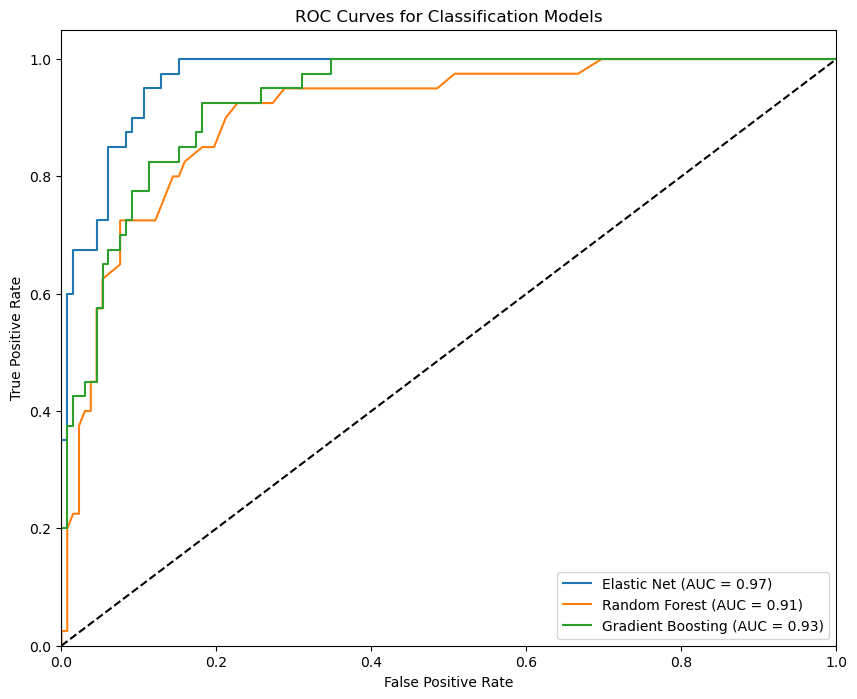


Results for differentially expressed genes:

Elastic Net:
AUC: 0.970

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       132
           1       0.79      0.85      0.82        40

    accuracy                           0.91       172
   macro avg       0.87      0.89      0.88       172
weighted avg       0.92      0.91      0.91       172


Confusion Matrix:
[[123   9]
 [  6  34]]

Random Forest:
AUC: 0.907

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       132
           1       0.76      0.47      0.58        40

    accuracy                           0.84       172
   macro avg       0.81      0.71      0.74       172
weighted avg       0.83      0.84      0.83       172


Confusion Matrix:
[[126   6]
 [ 21  19]]

Gradient Boosting:
AUC: 0.932

Classification Report:
              precision    recall  f1-score   support

       

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    # Encode categorical labels
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Model Training & Evaluation Function for Classification
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Store results
        results[name] = {
            'AUC': roc_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classification Models')
    plt.legend(loc="lower right")
    plt.show()
    
    return results

# Main execution
def main():
    # # For top 2% expressed genes
    # print("Training models on top 2% expressed genes:")
    
    # # Classification
    # X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
    #     rnaseq_df_top_genes, brca_df_common['HRD_status_base'], task='classification'
    # )
    
    # results_top = train_evaluate_classification_models(
    #     X_train_top, X_test_top, y_train_top, y_test_top
    # )
    
    # For differentially expressed genes
    print("\nTraining models on differentially expressed genes:")
    
    X_train_de, X_test_de, y_train_de, y_test_de = preprocess_data(
        deseq_filtered_rna_seq_df_common, brca_df_common['HRD_status_base'], task='classification'
    )
    
    results_de = train_evaluate_classification_models(
        X_train_de, X_test_de, y_train_de, y_test_de
    )
    
    # # Print results
    # print("\nResults for top 2% expressed genes:")
    # for model_name, metrics in results_top.items():
    #     print(f"\n{model_name}:")
    #     print(f"AUC: {metrics['AUC']:.3f}")
    #     print("\nClassification Report:")
    #     print(metrics['Classification Report'])
    #     print("\nConfusion Matrix:")
    #     print(metrics['Confusion Matrix'])
    
    print("\nResults for differentially expressed genes:")
    for model_name, metrics in results_de.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])

# For regression task on Confidence values
def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'MSE': mse,
            'R2': r2
        }
        
        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Actual vs Predicted')
        plt.show()
    
    return results

# # Run regression models
# def run_regression():
#     print("\nTraining regression models for Confidence prediction:")
    
#     # For top 2% expressed genes
#     X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
#         rnaseq_df_top_genes, brca_df_common['Confidence'], task='regression'
#     )
    
#     results_top_reg = train_evaluate_regression_models(
#         X_train_top, X_test_top, y_train_top, y_test_top
#     )
    
#     print("\nRegression Results for top 2% expressed genes:")
#     for model_name, metrics in results_top_reg.items():
#         print(f"\n{model_name}:")
#         print(f"MSE: {metrics['MSE']:.6f}")
#         print(f"R2: {metrics['R2']:.3f}")

main()
#run_regression()

In [44]:
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 11 20_40_55 2025.csv')
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']]
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])
parpi_resp_filt

/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_44538/858282350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])


,Drug Name,Cell Line Name,IC50,log10IC50
0,Olaparib,HCC1954,4.017502,0.603956
1,Olaparib,HCC1143,5.307956,0.724927
2,Olaparib,HCC1187,4.459187,0.649256
3,Olaparib,HCC1395,3.496354,0.543615
4,Olaparib,HCC1599,4.608563,0.663565
...,...,...,...,...
384,Talazoparib,HDQ-P1,3.718242,0.570338
385,Talazoparib,JIMT-1,4.466165,0.649935
386,Talazoparib,HCC1500,5.377461,0.730577
387,Talazoparib,YMB-1-E,2.975015,0.473489


In [45]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import roc_curve, auc, mean_squared_error, r2_score

# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    if task == 'classification':
        # Encode labels for classification
        le = LabelEncoder()
        y = le.fit_transform(y)
    elif task == 'regression':
        y = np.array(y)  # Ensure the target is in the correct format
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Function to train and predict using Elastic Net
def elastic_net_predictions(X_train, y_train, X_validation, task='classification'):
    if task == 'classification':
        # Initialize Elastic Net Logistic Regression
        model = LogisticRegression(penalty='elasticnet', solver='saga', 
                                   l1_ratio=0.5, max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_validation)[:, 1]
        return y_pred_proba
    elif task == 'regression':
        # Initialize Elastic Net Regressor
        model = ElasticNet(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_validation)
        return y_pred

# Main Execution
def main():
    print("\nTraining Elastic Net model and generating predictions on validation data:")
    
    # Preprocessing
    X_train, X_test, y_train, y_test, scaler = preprocess_data(
        deseq_filtered_rna_seq_df, brca_df_common['HRD_status_base'], task='classification'
    )
    
    # Preprocess validation data
    X_validation_scaled = scaler.transform(breast_filt)
    
    # Train and predict using Elastic Net
    predictions = elastic_net_predictions(X_train, y_train, X_validation_scaled, task='classification')
    
    print("\nPredictions on validation data:")
    print(predictions)

# Call main
main()




Training Elastic Net model and generating predictions on validation data:


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- AZIN2
- B4GAT1
- BAHCC1
- CCDC183
- CCDC186
- ...
